# DeepStream과 MQTT

DeepStream을 활용하여 실시간 객체 감지 후, MQTT를 통해 감지된 데이터를 외부 시스템으로 전송하는 방법을 다룹니다. 이를 통해 IoT 장치, 클라우드 서비스, 데이터베이스 등 다양한 환경에서 실시간 감지 데이터를 활용할 수 있습니다.

## 04-2. MQTT란?
MQTT(Message Queuing Telemetry Transport)는 가벼운 메시징 프로토콜로, IoT 및 실시간 데이터 전송에 적합합니다. DeepStream에서는 감지된 객체 정보를 MQTT 브로커를 통해 퍼블리시하고, 다른 애플리케이션이 이를 구독하여 활용할 수 있습니다.

## 04-3. MQTT 활용 사례

MQTT는 경량 메시징 프로토콜로, 저지연성과 높은 신뢰성을 요구하는 다양한 산업에서 널리 사용됩니다. 다음은 대표적인 활용 사례입니다.

### 1. IoT 및 스마트 홈
* 스마트 조명, 온도 센서, 도어락과 같은 IoT 디바이스에서 상태 데이터를 전송하고 원격으로 제어하는 데 사용됩니다.
* 예: 스마트홈 시스템에서 MQTT를 활용하여 사용자의 스마트폰과 가전기기 간 통신을 수행.

### 2. 산업 자동화
* 제조업에서 센서 및 기계 데이터를 실시간으로 모니터링하고 원격으로 제어하는 데 활용됩니다.
* 예: 공장의 IoT 센서가 온도, 습도, 기계 작동 상태를 MQTT를 통해 중앙 제어 서버에 전송.

### 3. 차량 및 물류 시스템
* 차량의 위치, 속도, 연료 상태 등의 데이터를 MQTT를 통해 클라우드 서버로 전송하여 실시간 관리를 가능하게 합니다.
* 예: 물류 트래킹 시스템에서 차량이 특정 위치에 도착했을 때 MQTT 메시지를 발행하여 자동으로 배송 상태 업데이트.

### 4. 헬스케어 및 원격 진료
* 병원 내 환자의 바이탈 데이터(심박수, 혈압, 체온 등)를 실시간으로 의료진에게 전송하여 모니터링할 수 있습니다.
* 예: 스마트 의료기기가 환자의 생체 정보를 MQTT를 이용해 클라우드로 전송하고 의료진이 원격으로 모니터링.

### 5. 스마트 시티 및 공공 인프라
* 교통량 감지, 대기 오염 모니터링, 스마트 가로등 제어 등 도시 관리 시스템에서 MQTT가 활용됩니다.
* 예: 교통 신호 체계가 MQTT를 통해 차량 흐름 데이터를 수집하여 실시간 교통 패턴 최적화.

### 6. AI 및 Edge Computing
* AI 모델의 추론 결과를 실시간으로 다른 시스템에 공유하기 위해 MQTT를 사용할 수 있습니다.
* 예: DeepStream이 객체 감지 결과를 MQTT를 통해 클라우드 서버나 데이터베이스로 전송하여 실시간 분석.

---

# 실습 : DeepStream을 활용한 실시간 사람 감지 및 MQTT 메시지 전송

## 개요
이 실습에서는 **DeepStream과 GStreamer를 활용하여 실시간으로 카메라 영상을 분석하고**, 감지된 사람 객체 정보를 **MQTT(Message Queuing Telemetry Transport)** 를 통해 전송하는 방법을 배웁니다.

DeepStream은 NVIDIA의 AI 기반 영상 분석 프레임워크로, 실시간 객체 감지, 추적 및 분석을 수행할 수 있습니다. MQTT는 가볍고 효율적인 메시지 프로토콜로, 감지된 데이터를 다른 시스템에 전달하는 데 적합합니다.

이 실습을 완료하면, **카메라에서 감지된 사람 객체 정보를 MQTT 브로커를 통해 다른 애플리케이션에서 활용할 수 있는 환경을 구축**할 수 있습니다.

## 실습 목적
이 실습의 목적은 다음과 같습니다:
- **DeepStream을 이용한 실시간 영상 분석 방법 이해**
- **GStreamer 파이프라인을 구성하고 실행하는 방법 학습**
- **MQTT를 활용하여 감지된 객체 정보를 외부로 전송하는 방법 습득**
- **IoT 및 Edge AI 환경에서 실시간 객체 감지 데이터를 활용하는 방식 경험**

## 실습 개요
1. **카메라에서 실시간 영상 입력 받기**
2. **DeepStream을 활용하여 영상 내 사람 객체 감지**
3. **감지된 객체 정보를 MQTT 메시지로 변환**
4. **MQTT를 통해 감지된 객체 정보를 외부 시스템으로 전송**
5. **Jupyter Notebook이나 별도의 애플리케이션에서 MQTT 메시지 수신 및 활용**

## 환경설정

### 1. Mosquitto MQTT 브로커 설치
```bash
$ sudo apt update
$ sudo apt install mosquitto mosquitto-clients
```

Mosquitto 서비스 활성화:
```bash
$ sudo systemctl start mosquitto
$ sudo systemctl enable mosquitto
```

### 2. MQTT Python 클라이언트(paho-mqtt) 설치
```bash
$ pip install paho-mqtt
```

## DeepStream과 MQTT 연동
### 1. DeepStream 메시지 브로커 설정
DeepStream에서는 `nvds_msgbroker` 플러그인을 사용하여 MQTT로 데이터를 전송할 수 있습니다.

**Python 코드 내에 MQTT 설정 예시**:
```python
# MQTT 설정
MQTT_BROKER = "localhost"
MQTT_PORT = 1883
MQTT_TOPIC = "deepstream_person_detect"

client = mqtt.Client()
client.connect(MQTT_BROKER, MQTT_PORT, 60)
client.loop_start()

def send_mqtt_message(obj_meta):
    """감지된 객체 정보를 MQTT로 송신"""
    payload = {
        "object": "person",
        "confidence": obj_meta.confidence,
        "position": {
            "left": obj_meta.rect_params.left,
            "top": obj_meta.rect_params.top,
            "width": obj_meta.rect_params.width,
            "height": obj_meta.rect_params.height
        }
    }
    client.publish(MQTT_TOPIC, json.dumps(payload), qos=1)
    print(f"Sent MQTT message: {payload}")

def osd_sink_pad_buffer_probe(pad, info, u_data):
    """DeepStream에서 감지된 객체가 'person'이면 MQTT로 전송"""
    import pyds
    gst_buffer = info.get_buffer()
    if not gst_buffer:
        return Gst.PadProbeReturn.OK
    
    batch_meta = pyds.gst_buffer_get_nvds_batch_meta(hash(gst_buffer))
    if not batch_meta:
        return Gst.PadProbeReturn.OK
    
    l_frame = batch_meta.frame_meta_list
    while l_frame:
        frame_meta = pyds.NvDsFrameMeta.cast(l_frame.data)
        l_obj = frame_meta.obj_meta_list
        while l_obj:
            obj_meta = pyds.NvDsObjectMeta.cast(l_obj.data)
            if obj_meta.class_id == 2:  # 'person' 클래스
                send_mqtt_message(obj_meta)
            l_obj = l_obj.next
        l_frame = l_frame.next
    
    return Gst.PadProbeReturn.OK
```

### 2. DeepStream with MQTT 실행
* 실시간 카메라로 사람을 인식
* 인식된 객체를 JSON에 담아서 publishing
```bash
$ python3 DeepStream_MQTT.py
```

다음과 같이 객체를 인식해서 MQTT publishing 출력이 나오면 성공
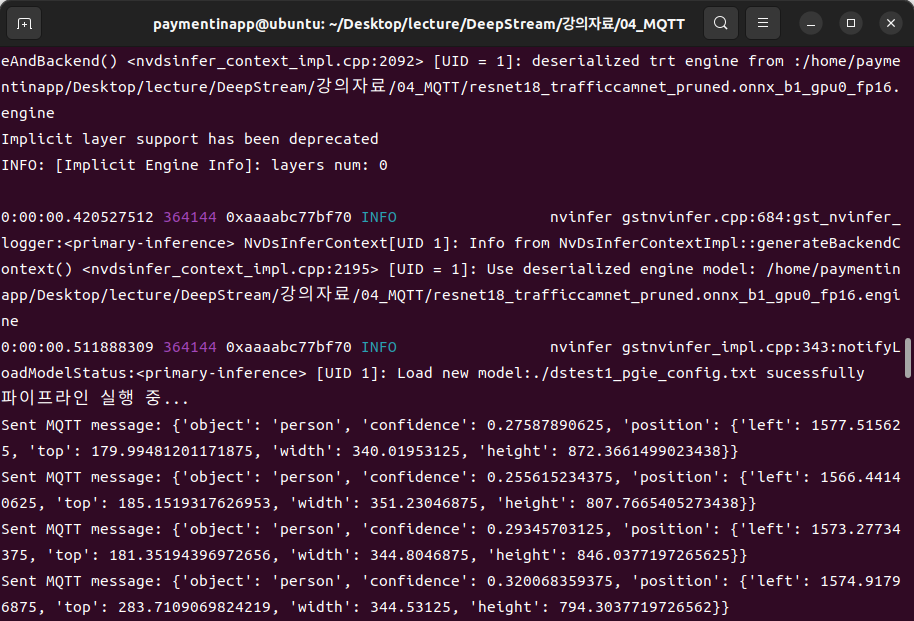

## MQTT 데이터 수신
### 1. Python MQTT Subscriber 작성
MQTT 데이터를 구독하고 출력하는 간단한 스크립트:

In [8]:
import paho.mqtt.client as mqtt

MQTT_BROKER = "localhost"
MQTT_PORT = 1883
MQTT_TOPIC = "deepstream_person_detect"

# MQTT 메시지 수신 콜백 함수
def on_message(client, userdata, msg):
    print(f"Received MQTT message: {msg.payload.decode()}")

# MQTT 클라이언트 설정
client = mqtt.Client()
client.on_message = on_message

client.connect(MQTT_BROKER, MQTT_PORT, 60)
client.subscribe(MQTT_TOPIC)

# 메시지 수신 대기
print(f"Listening for MQTT messages on topic: {MQTT_TOPIC}")
client.loop_forever()


/tmp/ipykernel_350048/3190843070.py:12: DeprecationWarning: Callback API version 1 is deprecated, update to latest version
  client = mqtt.Client()


Listening for MQTT messages on topic: deepstream_person_detect
Received MQTT message: {"object": "person", "confidence": 0.212890625, "position": {"left": 47.046871185302734, "top": 172.70506286621094, "width": 776.8359375, "height": 905.3096313476562}}
Received MQTT message: {"object": "person", "confidence": 0.2042236328125, "position": {"left": 0.546875, "top": 101.29651641845703, "width": 744.0234375, "height": 976.7182006835938}}
Received MQTT message: {"object": "person", "confidence": 0.287841796875, "position": {"left": 0.0, "top": 67.09672546386719, "width": 673.734375, "height": 1010.91796875}}
Received MQTT message: {"object": "person", "confidence": 0.200439453125, "position": {"left": 0.0, "top": 88.54720306396484, "width": 692.328125, "height": 989.4674682617188}}
Received MQTT message: {"object": "person", "confidence": 0.2098388671875, "position": {"left": 9.273443222045898, "top": 60.85390090942383, "width": 566.2890625, "height": 1017.1607666015625}}
Received MQTT mes

KeyboardInterrupt: 